In [48]:
!pip install graphviz


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
def f(x):
    return 3*x**2 - 4*x + 5

In [4]:
f(3.0)

20.0

In [5]:
xs = np.arange(-5, 5.25, 0.25)
print(xs)
ys = f(xs)
print(ys)

[-5.   -4.75 -4.5  -4.25 -4.   -3.75 -3.5  -3.25 -3.   -2.75 -2.5  -2.25
 -2.   -1.75 -1.5  -1.25 -1.   -0.75 -0.5  -0.25  0.    0.25  0.5   0.75
  1.    1.25  1.5   1.75  2.    2.25  2.5   2.75  3.    3.25  3.5   3.75
  4.    4.25  4.5   4.75  5.  ]
[100.      91.6875  83.75    76.1875  69.      62.1875  55.75    49.6875
  44.      38.6875  33.75    29.1875  25.      21.1875  17.75    14.6875
  12.       9.6875   7.75     6.1875   5.       4.1875   3.75     3.6875
   4.       4.6875   5.75     7.1875   9.      11.1875  13.75    16.6875
  20.      23.6875  27.75    32.1875  37.      42.1875  47.75    53.6875
  60.    ]


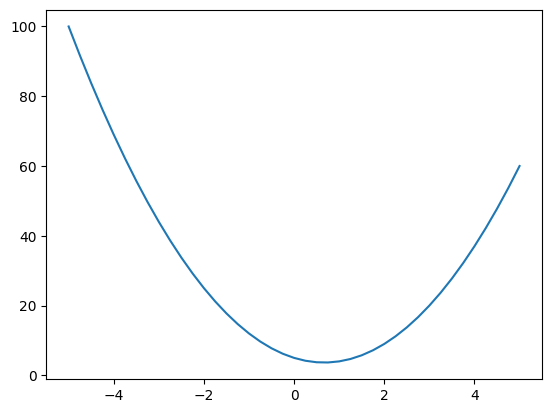

In [6]:
plt.plot(xs, ys)

In [18]:
h = 0.0000001
x = -3.0
(f(x + h) - f(x)) / h  # gives the slope/derivative for any point x

-21.999999688659955

In [21]:
# multivariable functions now

# inputs
a = 2
b = -3
c = 10.0

# func
d = a * b + c
print(d)

4.0


In [25]:
h = 0.00001

d1 = a*b + c
a += h
d2 = a*b + c

print("d1: ", d1)
print("d2:", d2) # is lower bcs increasing a leads to increasing the value of b which is negative- leading to a lower value
print("slope is: ", (d2 - d1) / h)  # diff d2 wrt a gives b, which is -3 (wrt a bcs we are only bumping up a itself here)

d1:  3.99991
d2: 3.999879999999999
slope is:  -3.000000000064062


# Neural Networks go here
starts with core implementation of `Value()` from micrograd!

In [152]:
class Value:
    """Class for presenting a variable with some value with inbuilt arithmetic operations"""
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0
        # self._backward performs chain rule for all inputs, with each operation having a separate definition
        self._backward = lambda: None  # the product of local derivative and the global derivative(final output of expressn wrt a variable) or the upstream gradient
        self._prev = set(_children)  # helps tracking back and in generation of computational graph
        self._op = _op  # good to know which operations led to which result
        self.label = label
    
    def __repr__(self):
        """Changes how the data object is presented"""
        return f"Value(data={self.data})"

    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            """Addition's gradient essentially distributes the global gradient to the inputs"""
            # NOTE: always add the gradients, not "set" them as they will be overwritten every time the variable is used more than once!! 
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward  # storing a reference to the function that can be called at any time
        
        return out 
        
    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            """Multiplication's local derivative is just the value of the other input"""
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        
        return out

    def tanh(self):
        x = self.data
        t = (math.exp(2 * x) - 1) / (math.exp(2 * x) + 1)
        out = Value(t, (self, ), 'tanh')
        
        def _backward():
            """Local derivative for tanh is (1 - tanh(x) ** 2)"""
            self.grad += (1 - t ** 2) * out.grad
        out._backward = _backward
        
        return out

    def backward(self):
        topo = []
        visited = set()
        def build_topology(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topology(child)
                topo.append(v)
        build_topology(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()
        

a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')

e = a * b
e.label = 'e'
d = e + c
d.label = 'd'

f = Value(-2.0, label='f')
L = d * f
L.label = 'L'

print("d: ", d)
print("The above expression works the same as this to give: ", (a.__mul__(b)).__add__(c))

d:  Value(data=4.0)
The above expression works the same as this to give:  Value(data=4.0)


In [46]:
print(d._prev)  # gives the children nodes for the item which resulted into d

{Value(data=10.0), Value(data=-6.0)}


In [66]:
from graphviz import Digraph

def trace(root):
    # builds a set of all nodes and graphs in a graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})  # LR: left to right
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in graph, create a rectangular 'record' node for it
        dot.node(name=uid, label="{ %s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            # if this value is a result of some operation, create an op node for it
            dot.node(name=uid + n._op, label=n._op)
            # and connect this node to it
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

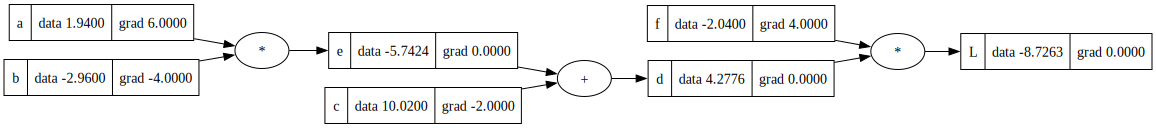

In [94]:
draw_dot(L)

In [95]:
def lol():
    h = 0.001  
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f; L.label = 'L'
    L1 = L.data
    
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    b.data += h
    c = Value(10.0, label='c')
    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f; L.label = 'L'
    L2 = L.data
    
    print((L2 - L1)/h)
  
lol()

-3.9999999999995595


## Single optimization step
Not initializing gradients for all variables here, only the ones which are important

In [85]:
# Initializing values
a.grad = 6
b.grad = -4
c.grad = -2
f.grad = 4

a.data = 2
b.data = -3
c.data = 10
f.data = -2

### Gradient Ascent
This will increase the value of L as the gradient points towards the direction of increased value for any var.

In [91]:
a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
f.data += 0.01 * f.grad

e = a * b
e.label = 'e'
d = e + c
d.label = 'd'
L = d * f
L.label = 'L'

print(L.data)

-7.286496


### Gradient Descent
This will decrease the value of L as the gradient points towards the direction of increased value and we are going opposite of the gradient's direction.

In [93]:
a.data -= 0.01 * a.grad
b.data -= 0.01 * b.grad
c.data -= 0.01 * c.grad
f.data -= 0.01 * f.grad

e = a * b
e.label = 'e'
d = e + c
d.label = 'd'
L = d * f
L.label = 'L'

print(L.data)

-8.726303999999999


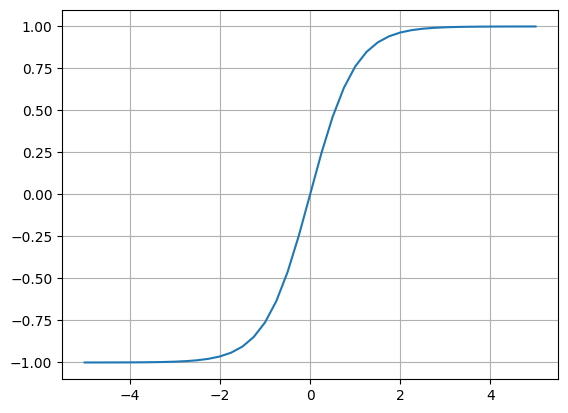

In [96]:
# plotting tanh, which squashes input values down to a range of -1 to 1
plt.plot(np.arange(-5, 5.25, 0.25), np.tanh(np.arange(-5, 5.25, 0.25)))
plt.grid()

## Neuron stuff!

In [143]:
# inputs
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of neuron
b = Value(6.88137, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label='x1*w1'
x2w2 = x2*w2; x2w2.label='x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label='x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'

# o = tanh(x1*w1 + x2*w2 + b)
o = n.tanh()  # needs to be implemented in Value() class!
o.label = 'o'

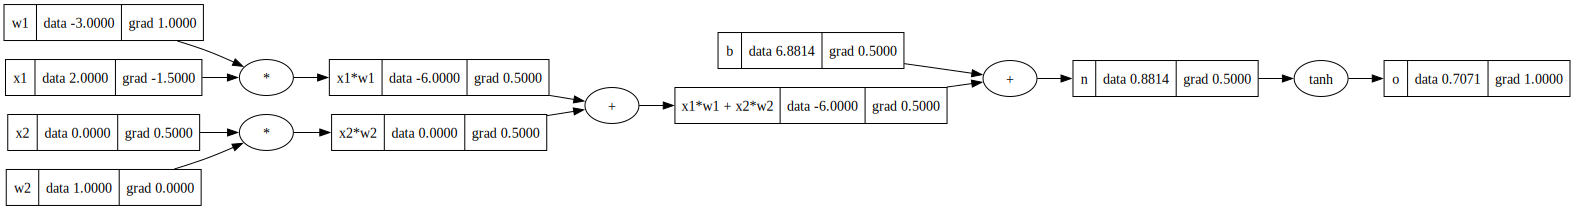

In [146]:
draw_dot(o)

### Backpropagating manually through the neuron (right to left)

In [102]:
o.grad = 1

In [104]:
# o = tanh(n)
# do/dn = 1 - tanh(n) ** 2
# or,
# do/dn = 1 - o ** 2
# hence, n.grad = 1 - o ** 2
1 - o.data ** 2

0.5000025364090595

In [105]:
n.grad = 0.5

In [108]:
# + operation acts as a distributor of gradients which in this case is n's gradient
x1w1x2w2.grad = 0.5
b.grad = 0.5

In [109]:
x1w1.grad = 0.5
x2w2.grad = 0.5

In [110]:
# * operation means that the local derivative is the value of the other item. i.e.,
x1.grad = w1.data * x1w1.grad
w1.grad = x1.data * x1w1.grad

In [114]:
x2.grad = w2.data * x2w2.grad
w2.grad = x2.data * x2w2.grad # its gradient is 0 because we are multiplying it by 0, hence it will have no effect on the output

### Backpropagating with _backward()

In [131]:
o.grad = 1

In [132]:
o._backward()

In [134]:
n._backward()

In [136]:
b._backward()  # nothing happens as b's _backward is empty :p
x1w1x2w2._backward()

In [138]:
x1w1._backward()
x2w2._backward()

### Topological sort
This forms the basis of how the computational graph for any nn is created, it starts from the output and goes back to all children nodes in their respective topological order and can be used to calculate the gradients for all sorts of nns. If we go back to the definition of backward() in Value()- we will see that we are reversing the order of the items, which leads to calculating the gradients for neurons from the output.

In [141]:
topo = []
visited = set()
def build_topology(v):
    if v not in visited:
        visited.add(v)
        for child in  v._prev:
            build_topology(child)
        topo.append(v)

build_topology(o)
topo # starts from o but will append it to list at the end as the children get added first

[Value(data=6.88137),
 Value(data=-3.0),
 Value(data=2.0),
 Value(data=-6.0),
 Value(data=1.0),
 Value(data=0.0),
 Value(data=0.0),
 Value(data=-6.0),
 Value(data=0.8813700000000004),
 Value(data=0.7071049876722272)]

### Calculating the gradients with one backward() call

In [148]:
o.backward()

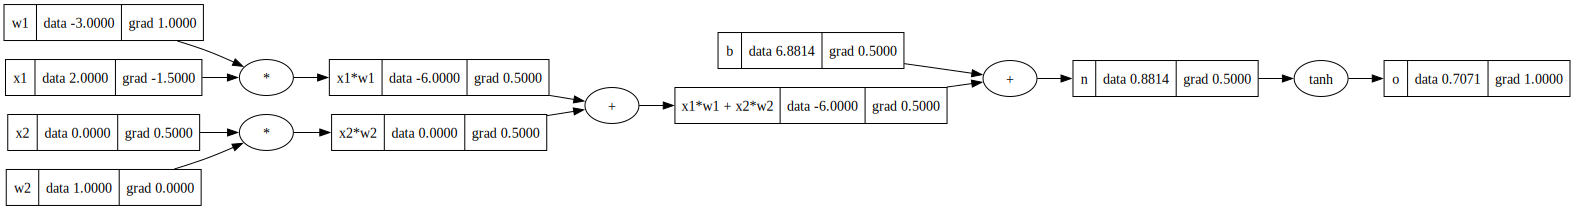

In [149]:
draw_dot(o)

## Overwriting gradients bug (fix by adding gradients instead of setting them)

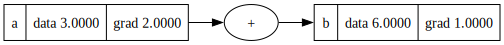

In [154]:
a = Value(3.0, label='a')
b = a + a   ; b.label = 'b'
b.backward()
draw_dot(b)

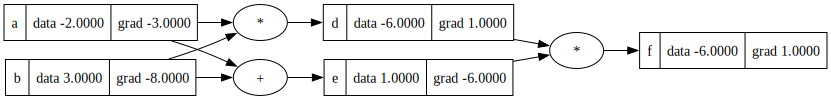

In [155]:
a = Value(-2.0, label='a')
b = Value(3.0, label='b')
d = a * b    ; d.label = 'd'
e = a + b    ; e.label = 'e'
f = d * e    ; f.label = 'f'

f.backward()

draw_dot(f)